# Support Vector Machine - 2 Hourly Taxi Demand Prediction

In this section we predict the 2-hourly demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

For that we proceed as follows:

- Build SVM model with different kernels to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best ones
- Build the model with found kernel and hyperparameters: make predictions for all spatial units
- Evaluation

<hr style="border: 1px solid #8888;">

In [2]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import datasets
from scipy.stats import loguniform
# import .py file for prediction methods
import predictive as pred

<hr style="border: 1px solid #8888;">

## Preprocessing

In [3]:
# import datasets
df_2h_comar = pd.read_csv("data/datasets/df_2h_comar.csv")
df_2h_hexlow = pd.read_csv("data/datasets/df_2h_hexlow.csv")
df_2h_hexmed = pd.read_csv("data/datasets/df_2h_hexmed.csv")
df_2h_hexhig = pd.read_csv("data/datasets/df_2h_hexhig.csv")

In [ ]:
plt.figure(figsize=(12,4)) 

plt.subplot(121)  
df_2h_comar['numOfTaxis_area'].plot.hist()

plt.subplot(122)
df_2h_comar['numOfTaxis_area'] = np.log(df_2h_comar['numOfTaxis_area'])
df_2h_comar['numOfTaxis_area'].plot.hist()
plt.show()

In [4]:
df_2h_comar.drop(columns = ['date_start'],inplace = True)
df_2h_hexlow.drop(columns = ['date_start'],inplace = True)
df_2h_hexmed.drop(columns = ['date_start'],inplace = True)
df_2h_hexhig.drop(columns = ['date_start'],inplace = True)

In [5]:
df_2h_comar = pred.dayandseas_to_int(df_2h_comar)
df_2h_hexlow = pred.dayandseas_to_int(df_2h_hexlow)
df_2h_hexmed = pred.dayandseas_to_int(df_2h_hexmed)
df_2h_hexhig = pred.dayandseas_to_int(df_2h_hexhig)

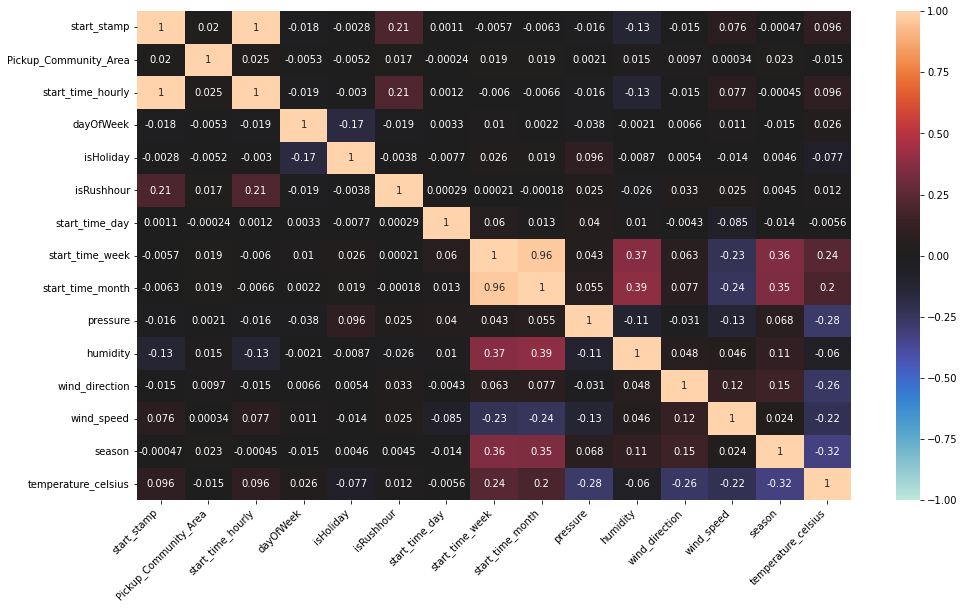

In [6]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_2h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

We have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`. In addition to that we have a perfect correlation between `start_time_hourly` and `start_stamp` (because we look at 2-hourly data and `start_stamp` represents the start of the interval). So we drop `start_time_hourly`, because we are interested in the 6-hourly interval (which start is represented by `start_stamp`):

In [ ]:
df_2h_comar.drop(columns = ['start_time_month'],inplace = True)

In [ ]:
df_2h_comar.drop(columns = ['start_time_hourly'],inplace = True)

Doing the same for the dataframes of:

- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

In [13]:
df_2h_hexlow.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_2h_hexmed.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_2h_hexhig.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)

<hr style="border: 1px solid #8888;">

## 2 Hourly Demand - Community Area

In [5]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_2h_comar,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [6]:
categoric, numeric = pred.cat_and_num('Pickup_Community_Area', False)

### Building the model: Checking for the best kernel

#### SVR KERNEL: LINEAR

In [7]:
svr_lin = SVR(kernel = 'linear',verbose = 10,cache_size=15000, max_iter=50000)

In [8]:
pipeline = pred.pipeline_fit_predict(svr_lin, categoric, numeric, x_train, y_train, x_val, y_val,
                               df_2h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -3557289.274868, rho = -22.790468
nSV = 79162, nBSV = 75865


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  37.282
MSE:  13478.358
RMSE:  116.096
Accuracy: 43.31 %
R2:  60.875 %
Max Residual Error:  1994.164


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 2

In [11]:
svr_poly2 = SVR(kernel = 'poly',degree = 2, verbose = 10,cache_size=15000, max_iter=50000)

In [13]:
pipeline = pred.pipeline_fit_predict(svr_poly2, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_2h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -5359909.670669, rho = -10.815140
nSV = 92121, nBSV = 90207


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  51.410
MSE:  30873.496
RMSE:  175.709
Accuracy: 21.83 %
R2:  10.381 %
Max Residual Error:  2488.999


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 3

In [14]:
svr_poly3 = SVR(kernel = 'poly',verbose = 10,cache_size=15000, max_iter=50000)

In [15]:
pipeline = pred.pipeline_fit_predict(svr_poly3, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_2h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -5567326.040863, rho = -8.122697
nSV = 92283, nBSV = 88934


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  54.792
MSE:  33231.783
RMSE:  182.296
Accuracy: 16.69 %
R2:  3.535 %
Max Residual Error:  2522.856


#### SVR KERNEL: RBF

In [16]:
svr_rbf = SVR(kernel = 'rbf',verbose = 10,cache_size=15000, max_iter=50000)

In [17]:
pipeline =pred.pipeline_fit_predict(svr_rbf, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_2h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -5389678.757735, rho = -7.296987
nSV = 92888, nBSV = 90262


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  51.597
MSE:  30760.551
RMSE:  175.387
Accuracy: 21.55 %
R2:  10.709 %
Max Residual Error:  2493.539


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model

#### Sampling data for tuning:

In [6]:
x_val, y_val = pred.sampling_already_splitted(x_val, y_val, 'numOfTaxis_area', 5000)

In [7]:
# creating the ranges for model parameter to use in find_best_hyperparameters

model_para = {'model__C':loguniform(1e-1, 1e2),        
                'model__epsilon':loguniform(1e-1, 1e2)}               

In [8]:
svr_lin = SVR(kernel = 'linear',cache_size=15000, max_iter=50000)

In [9]:
pipeline = pred.pipeline_for_prediction(categoric, numeric, svr_lin)

In [10]:
pred.find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_absolute_error', verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-72.789 total time=   0.3s
[CV 2/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 2/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-71.923 total time=   0.3s
[CV 3/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 3/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-67.398 total time=   0.3s
[CV 4/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 4/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-67.518 total time=   0.3s
[CV 5/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 5/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-69.516 total time=   0.3s
[CV 6/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.1447600934

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-26.993 total time=   1.1s
[CV 2/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-25.743 total time=   1.0s
[CV 3/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-22.138 total time=   1.1s
[CV 4/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-21.438 total time=   1.1s
[CV 5/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-24.055 total time=   1.0s
[CV 6/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-26.615 total time=   1.0s
[CV 7/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-25.166 total time=   1.1s
[CV 8/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-22.717 total time=   1.0s
[CV 9/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-22.338 total time=   1.0s
[CV 10/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-23.756 total time=   1.0s
[CV 11/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-26.962 total time=   1.0s
[CV 12/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-25.289 total time=   1.0s
[CV 13/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-23.225 total time=   1.0s
[CV 14/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-22.528 total time=   1.1s
[CV 15/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-22.585 total time=   1.0s
[CV 1/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 1/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-33.953 total time=   1.2s
[CV 2/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 2/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-32.710 total time=   1.2s
[CV 3/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 3/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-29.230 total time=   1.2s
[CV 4/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 4/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-28.637 total time=   1.2s
[CV 5/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-29.406 total time=   0.6s
[CV 2/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.864 total time=   0.6s
[CV 3/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-24.197 total time=   0.6s
[CV 4/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-23.840 total time=   0.6s
[CV 5/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-25.985 total time=   0.6s
[CV 6/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-29.191 total time=   0.6s
[CV 7/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.607 total time=   0.6s
[CV 8/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-24.582 total time=   0.6s
[CV 9/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-24.532 total time=   0.6s
[CV 10/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-25.709 total time=   0.7s
[CV 11/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-29.335 total time=   0.6s
[CV 12/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-27.794 total time=   0.6s
[CV 13/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-24.882 total time=   0.6s
[CV 14/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-24.867 total time=   0.6s
[CV 15/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-24.766 total time=   0.6s
[CV 1/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 1/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-86.155 total time=   0.3s
[CV 2/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 2/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-84.983 total time=   0.3s
[CV 3/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 3/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-81.267 total time=   0.3s
[CV 4/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 4/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-81.035 total time=   0.3s
[CV 5/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-26.086 total time=   2.6s
[CV 2/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-24.997 total time=   2.7s
[CV 3/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-21.531 total time=   2.7s
[CV 4/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-20.901 total time=   2.6s
[CV 5/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-23.457 total time=   2.6s
[CV 6/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-25.844 total time=   2.6s
[CV 7/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-24.367 total time=   2.7s
[CV 8/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-22.126 total time=   2.6s
[CV 9/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-21.729 total time=   2.7s
[CV 10/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-23.029 total time=   2.6s
[CV 11/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-26.092 total time=   2.7s
[CV 12/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-24.519 total time=   2.7s
[CV 13/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-22.600 total time=   2.7s
[CV 14/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-22.070 total time=   2.7s
[CV 15/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-21.967 total time=   2.6s
[CV 1/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 1/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-33.446 total time=   1.2s
[CV 2/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 2/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-32.169 total time=   1.2s
[CV 3/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 3/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-28.721 total time=   1.2s
[CV 4/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 4/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-28.131 total time=   1.2s
[CV 5/15; 8/50] START model__C=0.3511356313970407, model__eps

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-28.692 total time=   1.3s
[CV 2/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-27.267 total time=   1.3s
[CV 3/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-23.674 total time=   1.3s
[CV 4/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-23.266 total time=   1.3s
[CV 5/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-25.001 total time=   1.3s
[CV 6/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-28.327 total time=   1.3s
[CV 7/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-27.335 total time=   1.3s
[CV 8/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-24.042 total time=   1.3s
[CV 9/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-23.348 total time=   1.3s
[CV 10/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-24.835 total time=   1.3s
[CV 11/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-28.698 total time=   1.3s
[CV 12/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-27.705 total time=   1.3s
[CV 13/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-23.702 total time=   1.4s
[CV 14/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-23.369 total time=   1.3s
[CV 15/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-24.280 total time=   1.3s
[CV 1/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-26.532 total time=   1.8s
[CV 2/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-25.232 total time=   1.9s
[CV 3/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-21.554 total time=   1.8s
[CV 4/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-20.990 total time=   1.8s
[CV 5/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-23.576 total time=   1.8s
[CV 6/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-26.543 total time=   1.8s
[CV 7/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-24.770 total time=   1.8s
[CV 8/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-22.138 total time=   1.8s
[CV 9/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-21.622 total time=   1.8s
[CV 10/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-23.141 total time=   1.8s
[CV 11/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-26.644 total time=   1.8s
[CV 12/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-25.339 total time=   1.8s
[CV 13/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-22.278 total time=   1.8s
[CV 14/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-21.892 total time=   1.8s
[CV 15/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-22.167 total time=   1.8s
[CV 1/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 1/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-31.112 total time=   1.1s
[CV 2/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 2/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-29.901 total time=   1.1s
[CV 3/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 3/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-26.420 total time=   1.1s
[CV 4/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 4/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-25.991 total time=   1.1s
[CV 5/15; 12/50] START model__C=0.7523742884534856, model__eps

[CV 10/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-28.712 total time=   0.8s
[CV 11/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 11/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-33.089 total time=   0.8s
[CV 12/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 12/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-32.225 total time=   0.8s
[CV 13/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 13/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-28.548 total time=   0.8s
[CV 14/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 14/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-28.047 total time=   0.8s
[CV 15/15; 14/50] START model__C=0.3972110727381912,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-26.671 total time=   1.8s
[CV 2/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-25.322 total time=   1.8s
[CV 3/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-21.663 total time=   1.8s
[CV 4/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-21.225 total time=   1.8s
[CV 5/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-23.679 total time=   1.8s
[CV 6/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-26.684 total time=   1.8s
[CV 7/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-24.915 total time=   1.8s
[CV 8/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-22.161 total time=   1.8s
[CV 9/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-21.731 total time=   1.8s
[CV 10/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-23.188 total time=   1.8s
[CV 11/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-26.867 total time=   1.8s
[CV 12/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-25.471 total time=   1.8s
[CV 13/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-22.337 total time=   1.8s
[CV 14/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-21.924 total time=   1.8s
[CV 15/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-22.267 total time=   1.8s
[CV 1/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-26.563 total time=   1.7s
[CV 2/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-25.254 total time=   1.8s
[CV 3/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-21.564 total time=   1.8s
[CV 4/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-20.999 total time=   1.8s
[CV 5/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-23.598 total time=   1.8s
[CV 6/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-26.604 total time=   1.8s
[CV 7/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-24.803 total time=   1.7s
[CV 8/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-22.138 total time=   1.8s
[CV 9/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-21.629 total time=   1.8s
[CV 10/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-23.157 total time=   1.8s
[CV 11/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-26.650 total time=   1.8s
[CV 12/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-25.397 total time=   1.8s
[CV 13/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-22.320 total time=   1.8s
[CV 14/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-21.893 total time=   1.8s
[CV 15/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-22.178 total time=   1.8s
[CV 1/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 1/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-77.501 total time=   0.3s
[CV 2/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 2/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-76.356 total time=   0.3s
[CV 3/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 3/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-72.682 total time=   0.3s
[CV 4/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 4/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-72.382 total time=   0.3s
[CV 5/15; 17/50] START model__C=0.15673095467235415, model__

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-32.877 total time=   0.8s
[CV 2/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-31.345 total time=   0.8s
[CV 3/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-28.368 total time=   0.8s
[CV 4/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-27.647 total time=   0.8s
[CV 5/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-29.571 total time=   0.8s
[CV 6/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-32.142 total time=   0.8s
[CV 7/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-31.123 total time=   0.8s
[CV 8/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-28.115 total time=   0.8s
[CV 9/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-28.223 total time=   0.8s
[CV 10/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-29.681 total time=   0.8s
[CV 11/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-32.544 total time=   0.8s
[CV 12/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-30.492 total time=   0.8s
[CV 13/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-29.413 total time=   0.8s
[CV 14/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-28.912 total time=   0.8s
[CV 15/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-28.914 total time=   0.8s
[CV 1/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 1/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-30.850 total time=   1.3s
[CV 2/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 2/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.562 total time=   1.3s
[CV 3/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 3/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-26.044 total time=   1.3s
[CV 4/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-25.642 total time=   1.3s
[CV 5/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-26.554 total time=   1.3s
[CV 6/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-30.647 total time=   1.3s
[CV 7/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 7/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.792 total time=   1.3s
[CV 8/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-26.163 total time=   1.3s
[CV 9/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-25.410 total time=   1.3s
[CV 10/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-26.619 total time=   1.3s
[CV 11/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 11/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-30.610 total time=   1.3s
[CV 12/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 12/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-29.949 total time=   1.3s
[CV 13/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-26.113 total time=   1.3s
[CV 14/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 14/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-25.632 total time=   1.3s
[CV 15/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-26.325 total time=   1.3s
[CV 1/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-26.394 total time=   1.5s
[CV 2/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-25.155 total time=   1.5s
[CV 3/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-21.496 total time=   1.5s
[CV 4/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-20.848 total time=   1.5s
[CV 5/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-23.533 total time=   1.5s
[CV 6/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-26.119 total time=   1.5s
[CV 7/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-24.567 total time=   1.5s
[CV 8/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-22.099 total time=   1.5s
[CV 9/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-21.560 total time=   1.5s
[CV 10/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-23.155 total time=   1.5s
[CV 11/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-26.426 total time=   1.5s
[CV 12/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-24.845 total time=   1.5s
[CV 13/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-22.414 total time=   1.5s
[CV 14/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-21.887 total time=   1.5s
[CV 15/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-22.068 total time=   1.5s
[CV 1/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 1/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-34.769 total time=   0.9s
[CV 2/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 2/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-33.526 total time=   0.9s
[CV 3/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 3/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-30.048 total time=   0.9s
[CV 4/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 4/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-29.506 total time=   0.9s
[CV 5/15; 21/50] START model__C=0.2323350351539011, model__e

[CV 10/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-29.138 total time=   0.6s
[CV 11/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 11/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-33.536 total time=   0.6s
[CV 12/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 12/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-32.731 total time=   0.6s
[CV 13/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 13/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-28.692 total time=   0.6s
[CV 14/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 14/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-28.411 total time=   0.6s
[CV 15/15; 23/50] START model__C=0.5975027999960293, model__e

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-27.086 total time=   1.6s
[CV 2/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.686 total time=   1.6s
[CV 3/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-21.997 total time=   1.6s
[CV 4/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-21.679 total time=   1.6s
[CV 5/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-23.988 total time=   1.6s
[CV 6/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-27.032 total time=   1.6s
[CV 7/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.375 total time=   1.6s
[CV 8/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-22.445 total time=   1.6s
[CV 9/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-22.174 total time=   1.6s
[CV 10/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-23.425 total time=   1.6s
[CV 11/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-27.279 total time=   1.6s
[CV 12/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-25.906 total time=   1.6s
[CV 13/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-22.515 total time=   1.6s
[CV 14/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-22.219 total time=   1.6s
[CV 15/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-22.702 total time=   1.6s
[CV 1/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-31.134 total time=   0.9s
[CV 2/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-29.689 total time=   0.9s
[CV 3/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-26.635 total time=   0.9s
[CV 4/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-25.715 total time=   0.9s
[CV 5/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-27.999 total time=   0.9s
[CV 6/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-30.434 total time=   0.9s
[CV 7/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-29.446 total time=   0.9s
[CV 8/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-26.657 total time=   0.9s
[CV 9/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-26.642 total time=   0.9s
[CV 10/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-27.959 total time=   0.9s
[CV 11/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-31.020 total time=   0.9s
[CV 12/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-28.987 total time=   0.9s
[CV 13/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-27.775 total time=   0.9s
[CV 14/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-26.917 total time=   0.9s
[CV 15/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-27.007 total time=   0.9s
[CV 1/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-41.347 total time=   0.5s
[CV 2/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-38.980 total time=   0.5s
[CV 3/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-36.212 total time=   0.5s
[CV 4/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-35.831 total time=   0.5s
[CV 5/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-36.844 total time=   0.5s
[CV 6/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-39.753 total time=   0.5s
[CV 7/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-39.862 total time=   0.5s
[CV 8/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-35.334 total time=   0.5s
[CV 9/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-36.215 total time=   0.5s
[CV 10/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-38.111 total time=   0.5s
[CV 11/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-41.186 total time=   0.5s
[CV 12/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-38.286 total time=   0.5s
[CV 13/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-36.742 total time=   0.5s
[CV 14/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-36.340 total time=   0.5s
[CV 15/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-36.642 total time=   0.5s
[CV 1/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 1/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-47.276 total time=   0.3s
[CV 2/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 2/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-46.443 total time=   0.3s
[CV 3/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 3/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-42.237 total time=   0.3s
[CV 4/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 4/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-43.388 total time=   0.3s
[CV 5/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.2

[CV 10/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-31.405 total time=   1.1s
[CV 11/15; 30/50] START model__C=0.13667272915456222, model__epsilon=0.946217535646149
[CV 11/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-35.987 total time=   1.1s
[CV 12/15; 30/50] START model__C=0.13667272915456222, model__epsilon=0.946217535646149
[CV 12/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-34.855 total time=   1.1s
[CV 13/15; 30/50] START model__C=0.13667272915456222, model__epsilon=0.946217535646149
[CV 13/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-31.421 total time=   1.0s
[CV 14/15; 30/50] START model__C=0.13667272915456222, model__epsilon=0.946217535646149
[CV 14/15; 30/50] END model__C=0.13667272915456222, model__epsilon=0.946217535646149;, score=-30.687 total time=   1.1s
[CV 15/15; 30/50] START model__C=0.13667272915456222

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-29.442 total time=   1.3s
[CV 2/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-28.066 total time=   1.3s
[CV 3/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-24.331 total time=   1.3s
[CV 4/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-24.034 total time=   1.3s
[CV 5/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-25.497 total time=   1.3s
[CV 6/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-29.007 total time=   1.3s
[CV 7/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-28.208 total time=   1.3s
[CV 8/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-24.842 total time=   1.3s
[CV 9/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-23.903 total time=   1.3s
[CV 10/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-25.425 total time=   1.3s
[CV 11/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-29.312 total time=   1.3s
[CV 12/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-28.422 total time=   1.3s
[CV 13/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-24.460 total time=   1.3s
[CV 14/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-24.074 total time=   1.3s
[CV 15/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-24.958 total time=   1.3s
[CV 1/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-26.114 total time=   2.3s
[CV 2/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.016 total time=   2.4s
[CV 3/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-21.597 total time=   2.4s
[CV 4/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-20.907 total time=   2.4s
[CV 5/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-23.475 total time=   2.4s
[CV 6/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-25.851 total time=   2.3s
[CV 7/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-24.339 total time=   2.3s
[CV 8/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-22.134 total time=   2.3s
[CV 9/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-21.728 total time=   2.3s
[CV 10/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-23.081 total time=   2.3s
[CV 11/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-26.139 total time=   2.3s
[CV 12/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-24.555 total time=   2.4s
[CV 13/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-22.652 total time=   2.3s
[CV 14/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-22.033 total time=   2.4s
[CV 15/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-22.004 total time=   2.3s
[CV 1/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 1/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-31.613 total time=   0.8s
[CV 2/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 2/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-30.442 total time=   0.8s
[CV 3/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 3/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-26.973 total time=   0.8s
[CV 4/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 4/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-26.562 total time=   0.8s
[CV 5/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4

[CV 11/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-93.928 total time=   0.3s
[CV 12/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 12/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-92.695 total time=   0.3s
[CV 13/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 13/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-89.007 total time=   0.3s
[CV 14/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 14/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-88.822 total time=   0.3s
[CV 15/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 15/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-89.742 total time=   0.3s
[CV 1/15; 36/50] START model__C=20.73644517790503, m

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-26.118 total time=   2.4s
[CV 2/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-24.977 total time=   2.4s
[CV 3/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-21.462 total time=   2.4s
[CV 4/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-20.901 total time=   2.4s
[CV 5/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-23.431 total time=   2.4s
[CV 6/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-25.874 total time=   2.4s
[CV 7/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-24.313 total time=   2.4s
[CV 8/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-22.058 total time=   2.4s
[CV 9/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-21.583 total time=   2.4s
[CV 10/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-23.025 total time=   2.4s
[CV 11/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-26.157 total time=   2.4s
[CV 12/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-24.561 total time=   2.4s
[CV 13/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-22.425 total time=   2.4s
[CV 14/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-21.930 total time=   2.5s
[CV 15/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-21.949 total time=   2.5s
[CV 1/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 1/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-48.512 total time=   0.5s
[CV 2/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 2/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-47.345 total time=   0.5s
[CV 3/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 3/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-43.895 total time=   0.5s
[CV 4/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 4/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-43.285 total time=   0.5s
[CV 5/15; 37/50] START model__C=0.10388823104027935, model__epsilo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-29.586 total time=   0.6s
[CV 2/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-28.098 total time=   0.6s
[CV 3/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-24.631 total time=   0.7s
[CV 4/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-24.041 total time=   0.6s
[CV 5/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-26.226 total time=   0.7s
[CV 6/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-29.062 total time=   0.7s
[CV 7/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-27.721 total time=   0.7s
[CV 8/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-24.968 total time=   0.6s
[CV 9/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-24.898 total time=   0.7s
[CV 10/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-26.153 total time=   0.7s
[CV 11/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-29.470 total time=   0.7s
[CV 12/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-27.675 total time=   0.7s
[CV 13/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-25.528 total time=   0.7s
[CV 14/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-25.280 total time=   0.7s
[CV 15/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-25.089 total time=   0.7s
[CV 1/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-26.152 total time=   2.6s
[CV 2/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-24.974 total time=   2.5s
[CV 3/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-21.431 total time=   2.6s
[CV 4/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-20.905 total time=   2.5s
[CV 5/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-23.443 total time=   2.5s
[CV 6/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-25.880 total time=   2.5s
[CV 7/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-24.325 total time=   2.5s
[CV 8/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-22.060 total time=   2.5s
[CV 9/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-21.575 total time=   2.5s
[CV 10/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-23.041 total time=   2.6s
[CV 11/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-26.154 total time=   2.5s
[CV 12/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-24.550 total time=   2.6s
[CV 13/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-22.438 total time=   2.5s
[CV 14/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-21.938 total time=   2.5s
[CV 15/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-21.991 total time=   2.5s
[CV 1/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 1/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-29.919 total time=   1.4s
[CV 2/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-28.615 total time=   1.4s
[CV 3/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-24.865 total time=   1.4s
[CV 4/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-24.477 total time=   1.4s
[CV 5/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-25.941 total time=   1.4s
[CV 6/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-29.527 total time=   1.4s
[CV 7/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-28.711 total time=   1.4s
[CV 8/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-25.329 total time=   1.4s
[CV 9/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-24.329 total time=   1.4s
[CV 10/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-25.846 total time=   1.4s
[CV 11/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-29.788 total time=   1.4s
[CV 12/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-28.937 total time=   1.4s
[CV 13/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-24.994 total time=   1.4s
[CV 14/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-24.559 total time=   1.4s
[CV 15/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-25.430 total time=   1.4s
[CV 1/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-27.151 total time=   1.3s
[CV 2/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-25.993 total time=   1.3s
[CV 3/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-22.508 total time=   1.3s
[CV 4/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-21.727 total time=   1.3s
[CV 5/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-24.280 total time=   1.3s
[CV 6/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-26.643 total time=   1.2s
[CV 7/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-25.254 total time=   1.3s
[CV 8/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-23.033 total time=   1.3s
[CV 9/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-22.653 total time=   1.3s
[CV 10/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-24.000 total time=   1.3s
[CV 11/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-27.080 total time=   1.3s
[CV 12/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-25.346 total time=   1.3s
[CV 13/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-23.759 total time=   1.3s
[CV 14/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-22.865 total time=   1.3s
[CV 15/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-22.838 total time=   1.3s
[CV 1/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-30.372 total time=   1.4s
[CV 2/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-29.014 total time=   1.4s
[CV 3/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-25.393 total time=   1.4s
[CV 4/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-25.009 total time=   1.4s
[CV 5/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-26.278 total time=   1.4s
[CV 6/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-29.973 total time=   1.4s
[CV 7/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 7/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-29.196 total time=   1.3s
[CV 8/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-25.738 total time=   1.4s
[CV 9/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-24.765 total time=   1.4s
[CV 10/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-26.205 total time=   1.4s
[CV 11/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-30.170 total time=   1.4s
[CV 12/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-29.381 total time=   1.4s
[CV 13/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-25.496 total time=   1.4s
[CV 14/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-25.020 total time=   1.4s
[CV 15/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-25.876 total time=   1.4s
[CV 1/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-30.668 total time=   1.2s
[CV 2/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 2/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-29.409 total time=   1.2s
[CV 3/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-25.922 total time=   1.2s
[CV 4/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 4/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-25.527 total time=   1.2s
[CV 5/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-26.482 total time=   1.2s
[CV 6/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 6/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-30.493 total time=   1.2s
[CV 7/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 7/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-29.622 total time=   1.2s
[CV 8/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 8/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-26.027 total time=   1.2s
[CV 9/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 9/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-25.281 total time=   1.2s
[CV 10/15; 43/50] START model__C=0.8569331925053982, model__e

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-26.515 total time=   1.2s
[CV 11/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 11/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-30.469 total time=   1.2s
[CV 12/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-29.803 total time=   1.2s
[CV 13/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 13/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-25.931 total time=   1.2s
[CV 14/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-25.506 total time=   1.2s
[CV 15/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 15/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-26.163 total time=   1.2s
[CV 1/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-27.455 total time=   0.9s
[CV 2/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.122 total time=   0.9s
[CV 3/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-22.574 total time=   0.9s
[CV 4/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-21.820 total time=   0.9s
[CV 5/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-24.428 total time=   0.9s
[CV 6/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-26.980 total time=   0.9s
[CV 7/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-25.612 total time=   0.9s
[CV 8/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-23.088 total time=   0.9s
[CV 9/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-22.788 total time=   0.9s
[CV 10/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-24.108 total time=   0.9s
[CV 11/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-27.365 total time=   0.9s
[CV 12/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-25.710 total time=   0.9s
[CV 13/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-23.600 total time=   0.9s
[CV 14/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-22.955 total time=   0.9s
[CV 15/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-23.015 total time=   0.9s
[CV 1/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-26.273 total time=   2.1s
[CV 2/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.148 total time=   2.2s
[CV 3/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-21.740 total time=   2.3s
[CV 4/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-21.057 total time=   2.2s
[CV 5/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-23.544 total time=   2.2s
[CV 6/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-25.866 total time=   2.2s
[CV 7/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-24.560 total time=   2.1s
[CV 8/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-22.338 total time=   2.2s
[CV 9/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-21.858 total time=   2.2s
[CV 10/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-23.227 total time=   2.2s
[CV 11/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-26.281 total time=   2.1s
[CV 12/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-24.665 total time=   2.2s
[CV 13/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-22.950 total time=   2.2s
[CV 14/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-22.175 total time=   2.2s
[CV 15/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-22.121 total time=   2.2s
[CV 1/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 1/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-39.048 total time=   0.6s
[CV 2/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 2/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-37.864 total time=   0.6s
[CV 3/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 3/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-34.395 total time=   0.6s
[CV 4/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 4/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-33.827 total time=   0.6s
[CV 5/15; 46/50] START model__C=0.22844556850020528, m

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-26.647 total time=   1.2s
[CV 2/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-25.521 total time=   1.3s
[CV 3/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-21.908 total time=   1.2s
[CV 4/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-21.238 total time=   1.2s
[CV 5/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-23.827 total time=   1.3s
[CV 6/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-26.313 total time=   1.2s
[CV 7/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-24.859 total time=   1.3s
[CV 8/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-22.485 total time=   1.3s
[CV 9/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-22.098 total time=   1.3s
[CV 10/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-23.521 total time=   1.3s
[CV 11/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-26.665 total time=   1.2s
[CV 12/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-25.053 total time=   1.2s
[CV 13/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-23.000 total time=   1.3s
[CV 14/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-22.317 total time=   1.3s
[CV 15/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-22.387 total time=   1.2s
[CV 1/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-26.327 total time=   1.6s
[CV 2/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-25.223 total time=   1.6s
[CV 3/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-21.659 total time=   1.6s
[CV 4/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-20.987 total time=   1.6s
[CV 5/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-23.584 total time=   1.6s
[CV 6/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-26.039 total time=   1.6s
[CV 7/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-24.574 total time=   1.6s
[CV 8/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-22.223 total time=   1.6s
[CV 9/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-21.778 total time=   1.6s
[CV 10/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-23.196 total time=   1.6s
[CV 11/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-26.374 total time=   1.5s
[CV 12/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-24.775 total time=   1.6s
[CV 13/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-22.671 total time=   1.6s
[CV 14/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-22.098 total time=   1.6s
[CV 15/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-22.153 total time=   1.5s
[CV 1/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-27.407 total time=   1.2s
[CV 2/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-25.977 total time=   1.2s
[CV 3/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-22.390 total time=   1.2s
[CV 4/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-22.052 total time=   1.2s
[CV 5/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-24.148 total time=   1.2s
[CV 6/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-27.459 total time=   1.2s
[CV 7/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-25.885 total time=   1.2s
[CV 8/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-22.764 total time=   1.2s
[CV 9/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-22.507 total time=   1.2s
[CV 10/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-23.701 total time=   1.2s
[CV 11/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-27.503 total time=   1.2s
[CV 12/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-26.405 total time=   1.2s
[CV 13/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-22.785 total time=   1.2s
[CV 14/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-22.430 total time=   1.2s
[CV 15/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-23.048 total time=   1.2s
[CV 1/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 1/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-36.365 total time=   1.2s
[CV 2/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 2/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-35.077 total time=   1.2s
[CV 3/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 3/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-31.666 total time=   1.2s
[CV 4/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 4/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-31.053 total time=   1.2s
[CV 5/15; 50/50] START model__C=0.11919481947

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [11]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.39459088111, C= 20.73644517790503,verbose = 10)

In [ ]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                     df_2h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -50476761.787977, rho = -9.335176
nSV = 56231, nBSV = 42104


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon low resolution 

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_2h_hexlow,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_low_res')

In [60]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [61]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                      df_2h_hexlow, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -106216334.908176, rho = -31.404760
nSV = 45998, nBSV = 34352


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  49.649
MSE:  19335.192
RMSE:  139.051
Accuracy: 42.61 %
R2:  59.394 %
Max Residual Error:  1997.387


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon medium resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_2h_hexmed,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_medium_res')

In [72]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [73]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_2h_hexmed, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -71769692.922822, rho = -9.900635
nSV = 53540, nBSV = 36094


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  21.106
MSE:  3232.545
RMSE:  56.855
Accuracy: 34.96 %
R2:  60.551 %
Max Residual Error:  1298.962


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon high resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_2h_hexhig,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_high_res')

In [78]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [79]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_2h_hexhig, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -54172541.831035, rho = -1.700378
nSV = 59016, nBSV = 39918


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  13.751
MSE:  628.844
RMSE:  25.077
Accuracy: 16.63 %
R2:  45.458 %
Max Residual Error:  599.243
